<a href="https://colab.research.google.com/github/aaln/aaln/blob/main/NVIDIA_DATA_HACKATHON_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
get_ipython().kernel.do_shutdown(restart=True)

{'status': 'ok', 'restart': True}

In [19]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
# Installing GPU driver for LightGBM:-
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
!sudo apt install nvidia-driver-460 nvidia-cuda-toolkit clinfo
!apt-get update --fix-missing
!pip install -q  lightgbm==4.1.0 \
  --config-settings=cmake.define.USE_GPU=ON \
  --config-settings=cmake.define.OpenCL_INCLUDE_DIR="/usr/local/cuda/include/" \
  --config-settings=cmake.define.OpenCL_LIBRARY="/usr/local/cuda/lib64/libOpenCL.so"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
clinfo is already the newest version (3.0.21.02.21-1).
Some packages could not be installed. This may mean that you have
requested an impossible situation or if you are using the unstable
distribution that some required packages have not yet been created
or been moved out of Incoming.
The following information may help to resolve the situation:

The following packages have unmet dependencies:
 libnvidia-compute-510 : Depends: libnvidia-compute-535 but it is not installable
 nvidia-cuda-dev : Breaks: libcuda1 (< 495)
                   Recommends: libnvcuvid1 but it is not installable
E: Unable to correct problems, you have held broken packages.
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Ign:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:

In [20]:
# Colab warns and provides remediation steps if the GPUs is not compatible with RAPIDS.

!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 535, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 535 (delta 174), reused 130 (delta 94), pack-reused 269 (from 1)
Receiving objects: 100% (535/535), 172.47 KiB | 2.27 MiB/s, done.
Resolving deltas: 100% (276/276), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.1 MB/s eta 0:00:00
Installing RAPIDS remaining 24.10.* libraries
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.7/567.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 GB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.5/915.5 kB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
%load_ext cudf.pandas

import cudf  # this should work without any errors
import cupy as cp
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, KBinsDiscretizer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_regression

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor

from scipy import stats
import gc
import shap

In [2]:
from google.colab import files
files.upload()  # Select kaggle.json from your local files (the api key)

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"aalndy","key":"3d3aac3e0773862d88152e8c280a92c2"}'}

In [3]:
!mkdir -p ~/.kaggle  # Use -p to avoid errors if the directory exists
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install -q kaggle

In [7]:

!kaggle competitions download -c odsc-2024-nvidia-hackathon

100% 3.70G/3.72G [00:20<00:00, 229MB/s]
100% 3.72G/3.72G [00:20<00:00, 197MB/s]


In [8]:
import zipfile
with zipfile.ZipFile("odsc-2024-nvidia-hackathon.zip", "r") as zip_ref:
    zip_ref.extractall("odsc-2024-nvidia-hackathon")

In [4]:
# prompt: train = pd.read_csv('odsc-2024-nvidia-hackathon/train.csv', sample 1000)
# test = pd.read_csv('odsc-2024-nvidia-hackathon/test.csv', sample 1000)

# Assuming the files are in the specified directory
train = pd.read_csv('odsc-2024-nvidia-hackathon/train.csv', nrows=2000000)
test = pd.read_csv('odsc-2024-nvidia-hackathon/test.csv')

In [5]:
# Check for missing values (in case some need imputation)
print(train.isnull().sum())
print(test.isnull().sum())

# Basic Feature Preprocessing
# Extract feature columns and target
target = train['y']
features = train.drop(['id', 'y'], axis=1)

id                       0
y                        0
trickortreat        976662
kingofhalloween    1026793
mumming            1054562
                    ...   
satan                    0
monsterhunter       400267
tabulatable         479359
vampire                  0
hallo               468437
Length: 108, dtype: int64
id                       0
y                  1000000
trickortreat         88960
kingofhalloween      93404
mumming              95907
                    ...   
satan                    0
monsterhunter        36560
tabulatable          43653
vampire                  0
hallo                43008
Length: 108, dtype: int64


In [6]:
# Label Encoding for Categorical Features using pandas factorize
categorical_cols = features.select_dtypes(include=['object']).columns
for col in categorical_cols:
    features[col], _ = pd.factorize(features[col])


In [7]:
# Handle the test data similarly to ensure columns align with training set
test_features = test.drop(['id'], axis=1)
for col in categorical_cols:
    if col in test_features.columns:
        test_features[col], _ = pd.factorize(test_features[col])

In [8]:

# Align train and test dataframes to have the same columns
features, test_features = features.align(test_features, join='left', axis=1, fill_value=0)



In [10]:
train['trickortreat_group'] = train['trickortreat'].str.split('_').str[0]
train['kingofhalloween_group'] = train['kingofhalloween'].str.split('_').str[0]

In [11]:

# Perform a groupby aggregation on the 'trickortreat_group' column and merge it back to the original dataset
trickortreat_grouped_data = train.groupby('trickortreat_group').agg({
    'y': 'mean',  # Example: calculate the mean for target variable 'y'
    # Add other columns with valid aggregation functions as needed, like sum, max, min, etc.
}).reset_index()

# Merge the aggregated data back to the original dataset
train = train.merge(trickortreat_grouped_data, on='trickortreat_group', suffixes=('', '_trickortreat_grouped'))

# Perform a groupby aggregation on the 'kingofhalloween_group' column and merge it back to the original dataset
kingofhalloween_grouped_data = train.groupby('kingofhalloween_group').agg({
    'y': 'mean',  # Example: calculate the mean for target variable 'y'
    # Add other columns with valid aggregation functions as needed, like sum, max, min, etc.
}).reset_index()

# Merge the aggregated data back to the original dataset
train = train.merge(kingofhalloween_grouped_data, on='kingofhalloween_group', suffixes=('', '_kingofhalloween_grouped'))

# Drop the group columns after merging, as they are no longer needed
train = train.drop(columns=['trickortreat_group', 'kingofhalloween_group'])

In [12]:

# Cross Validation to Determine Feature Importance
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lgb_model = LGBMRegressor(objective='regression', metric='rmse', boosting_type='gbdt',
                          learning_rate=0.1, max_depth=-1, num_leaves=31, device='gpu')


In [ ]:

# Perform cross-validation and obtain feature importances
cv_results = cross_val_score(lgb_model, features, target, cv=kf, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-cv_results)
print(f'Cross-Validation RMSE Scores: {rmse_scores}')
print(f'Mean Cross-Validation RMSE: {rmse_scores.mean()}')

In [ ]:

# Fit model to calculate feature importances
lgb_model.fit(features, target)
feature_importances = pd.DataFrame({'feature': features.columns, 'importance': lgb_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
print(feature_importances)

100%|===================| 199989/200000 [13:03<00:00]       

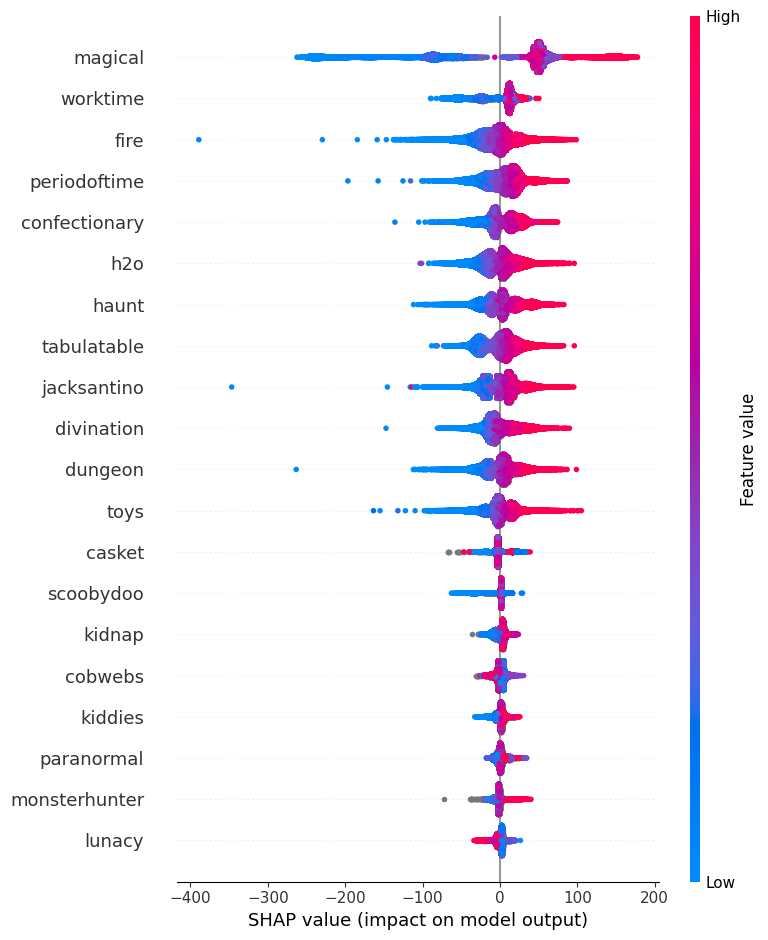

In [22]:

# SHAP Analysis for Feature Importance Explanation
explainer = shap.Explainer(lgb_model, features)
shap_values = explainer(features)
shap.summary_plot(shap_values, features)


In [24]:
from google.colab import files

# Assuming 'test' DataFrame is already loaded as in the provided code

# Create a smaller DataFrame with the first 100,000 rows
test_subset = test.head(10000)

# Save the subset to a CSV file
test_subset.to_csv('test_subset.csv', index=False)

# Download the CSV file
files.download('test_subset.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

# Split data into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.2, random_state=42)

# Convert to NumPy arrays for LightGBM compatibility
X_train = X_train.values
y_train = y_train.values
X_valid = X_valid.values
y_valid = y_valid.values

# LightGBM Dataset Construction (handle missing values automatically)
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train, free_raw_data=False)


In [ ]:

# Set LightGBM Parameters (ensure that CUDA and GPU support are installed and properly configured)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'gpu_platform_id': 0,  # Specify GPU platform (optional, depending on the setup)
    'gpu_device_id': 0,    # Specify GPU device ID (optional, depending on the setup)
    'learning_rate': 0.1,
    'max_depth': -1,
    'num_leaves': 31,
    'verbose': -1,
    'device': 'gpu',  # Enable GPU with CUDA for faster training  # Utilize GPU for faster training if available
}

# Train LightGBM Model with Callbacks
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=100)
]

model = lgb.train(params, lgb_train, num_boost_round=1000, valid_sets=[lgb_valid], callbacks=callbacks)



In [ ]:

# Predict on Validation Set
y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
rmse_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
print(f'Validation RMSE: {rmse_valid}')

# Predict on Test Set
test_features = test_features.values
test_preds = model.predict(test_features, num_iteration=model.best_iteration)

# Create Submission File
submission = pd.DataFrame({'id': test['id'], 'y': test_preds})
submission.to_csv('submission.csv', index=False)

print("Submission saved as 'submission.csv'")

